# Vowpal Wabbit: Learning with Gigabytes of Data

## Libraries

In [2]:
import os
import re

import numpy as np
import pandas as pd

from scipy.sparse import csr_matrix

from sklearn.datasets import fetch_20newsgroups, load_files
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    log_loss,
    roc_auc_score,
    roc_curve
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

## Stochastic gradient descent and online learning

### Stochastic gradient descent

In [4]:
# for Jupyter-book, we copy data from GitHub, locally, to save Internet traffic,
# you can specify the data/ folder from the root of your cloned
# https://github.com/Yorko/mlcourse.ai repo, to save Internet traffic
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/main/data/"

In [5]:
PATH_TO_WRITE_DATA = "../../data/"
data_demo = pd.read_csv(os.path.join(DATA_PATH, "weights_heights.csv"))

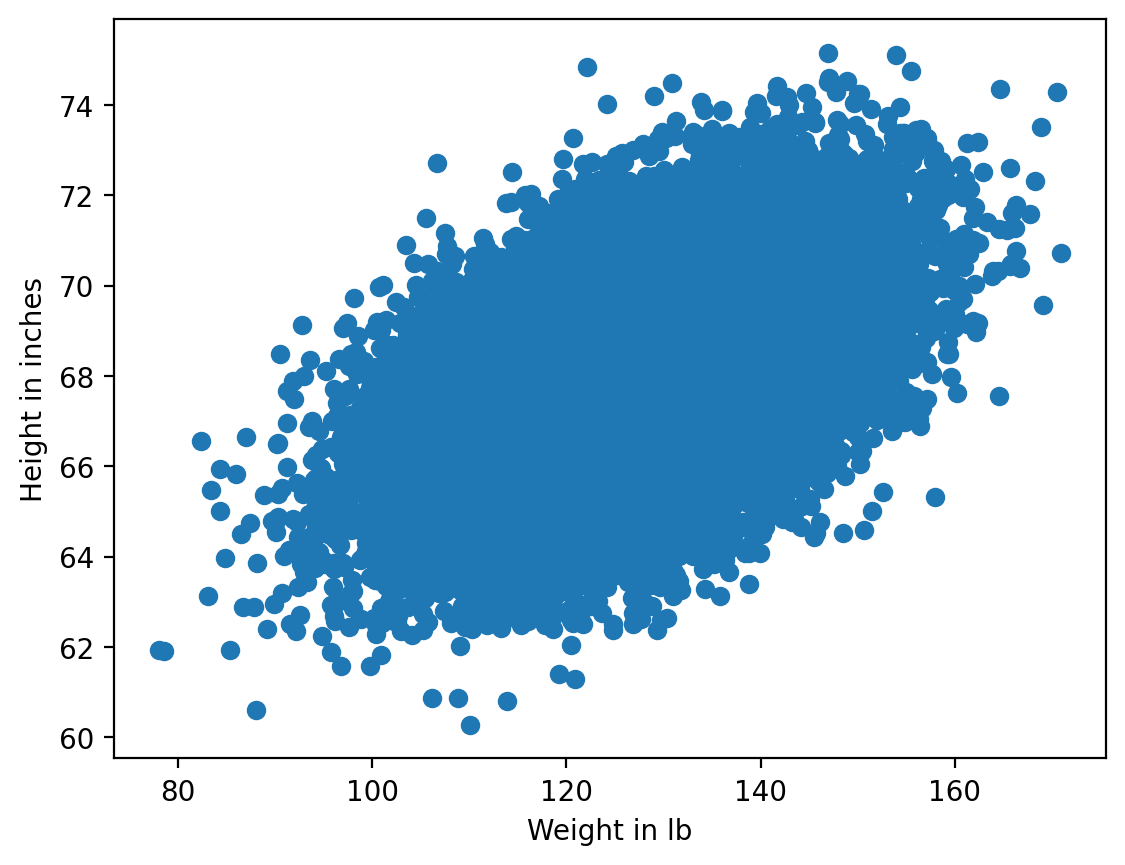

In [6]:
plt.scatter(data_demo["Weight"], data_demo["Height"])
plt.xlabel("Weight in lb")
plt.ylabel("Height in inches");

## Categorical feature processing

### Label Encoding

In [7]:
df = pd.read_csv(os.path.join(DATA_PATH, "bank_train.csv"))
labels = pd.read_csv(
    os.path.join(DATA_PATH, "bank_train_target.csv"), header=None
)

df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,26,student,single,high.school,no,no,no,telephone,jun,mon,901,1,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1
1,46,admin.,married,university.degree,no,yes,no,cellular,aug,tue,208,2,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1
2,49,blue-collar,married,basic.4y,unknown,yes,yes,telephone,jun,tue,131,5,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1
3,31,technician,married,university.degree,no,no,no,cellular,jul,tue,404,1,999,0,nonexistent,-2.9,92.469,-33.6,1.044,5076.2
4,42,housemaid,married,university.degree,no,yes,no,telephone,nov,mon,85,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8


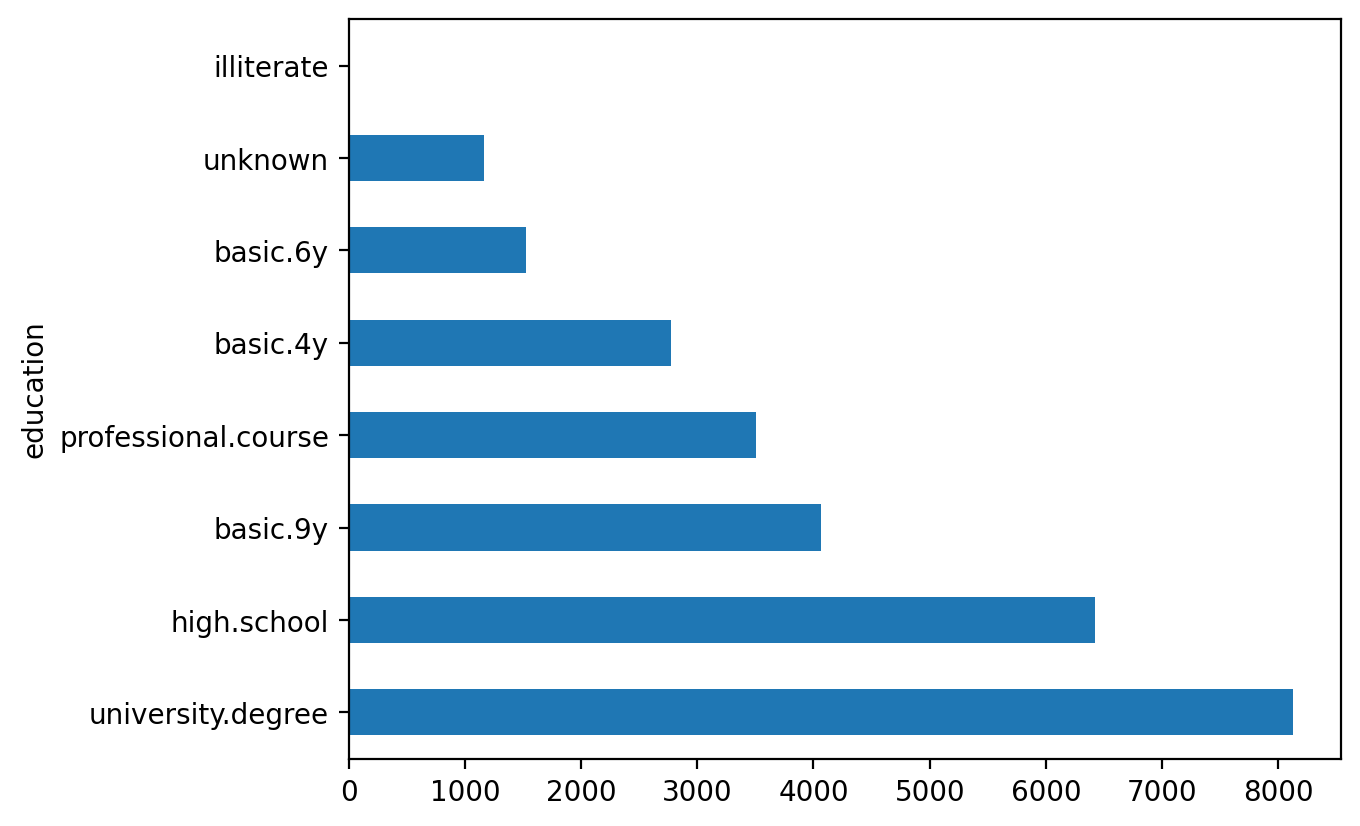

In [8]:
df["education"].value_counts().plot.barh();

{0: 'basic.4y', 1: 'basic.6y', 2: 'basic.9y', 3: 'high.school', 4: 'illiterate', 5: 'professional.course', 6: 'university.degree', 7: 'unknown'}


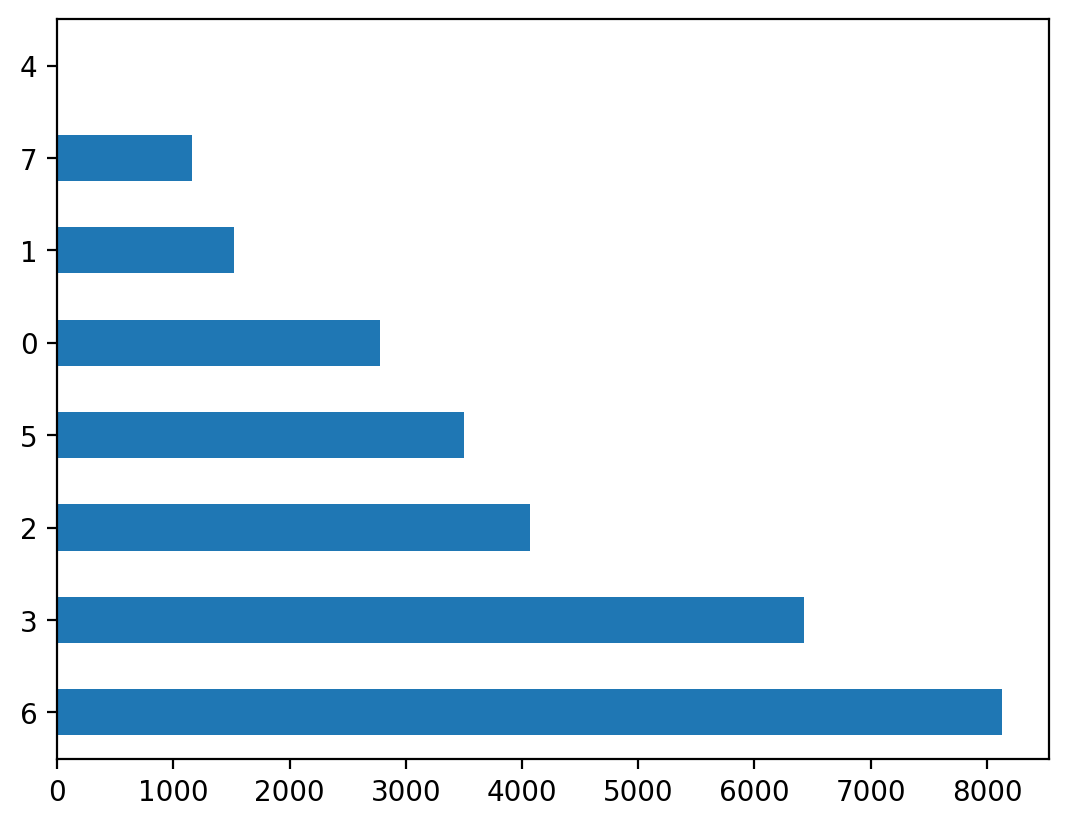

In [10]:
label_encoder = LabelEncoder()

mapped_education = pd.Series(label_encoder.fit_transform(df["education"]))
mapped_education.value_counts().plot.barh()
print(dict(enumerate(label_encoder.classes_)))

In [11]:
df["education"] = mapped_education
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,26,student,single,3,no,no,no,telephone,jun,mon,901,1,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1
1,46,admin.,married,6,no,yes,no,cellular,aug,tue,208,2,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1
2,49,blue-collar,married,0,unknown,yes,yes,telephone,jun,tue,131,5,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1
3,31,technician,married,6,no,no,no,cellular,jul,tue,404,1,999,0,nonexistent,-2.9,92.469,-33.6,1.044,5076.2
4,42,housemaid,married,6,no,yes,no,telephone,nov,mon,85,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8


In [13]:
categorical_columns = df.columns[df.dtypes == "object"].union(["education"])
for column in categorical_columns:
    df[column] = label_encoder.fit_transform(df[column])
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,26,8,2,3,0,0,0,1,4,1,901,1,999,0,1,1.4,94.465,-41.8,4.961,5228.1
1,46,0,1,6,0,2,0,0,1,3,208,2,999,0,1,1.4,93.444,-36.1,4.963,5228.1
2,49,1,1,0,1,2,2,1,4,3,131,5,999,0,1,1.4,94.465,-41.8,4.864,5228.1
3,31,9,1,6,0,0,0,0,3,3,404,1,999,0,1,-2.9,92.469,-33.6,1.044,5076.2
4,42,3,1,6,0,2,0,1,7,1,85,1,999,0,1,-0.1,93.200,-42.0,4.191,5195.8


In [21]:
def logistic_regression_accuracy_on(dataframe, labels):
    features = dataframe
    train_features, test_features, train_labels, test_labels = train_test_split(
        features, labels
    )

    logit = LogisticRegression()
    logit.fit(train_features, train_labels)
    return classification_report(test_labels, logit.predict(test_features))


print(logistic_regression_accuracy_on(df[categorical_columns], labels))

/home/diego/miniconda3/envs/ds-min/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.89      1.00      0.94      6141
           1       1.00      0.00      0.00       758

    accuracy                           0.89      6899
   macro avg       0.95      0.50      0.47      6899
weighted avg       0.90      0.89      0.84      6899



### One-Hot Encoding

In [22]:
one_hot_example = pd.DataFrame([{i: 0 for i in range(10)}])
one_hot_example.loc[0, 6] = 1
one_hot_example

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,1,0,0,0


In [24]:
onehot_encoder = OneHotEncoder(sparse_output=False)

encoded_categorical_columns = pd.DataFrame(
    onehot_encoder.fit_transform(df[categorical_columns])
)
encoded_categorical_columns.head()

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [27]:
print(logistic_regression_accuracy_on(encoded_categorical_columns, labels))

/home/diego/miniconda3/envs/ds-min/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.90      0.99      0.94      6108
           1       0.63      0.17      0.27       791

    accuracy                           0.89      6899
   macro avg       0.77      0.58      0.61      6899
weighted avg       0.87      0.89      0.87      6899



### Hashing trick

In [28]:
for s in ("university.degree", "high.school", "illiterate"):
    print(s, "->", hash(s))

university.degree -> 8825673054726571823
high.school -> -689116331952148968
illiterate -> 3609535572606330255


In [29]:
hash_space = 25
for s in ("university.degree", "high.school", "illiterate"):
    print(s, "->", hash(s) % hash_space)

university.degree -> 23
high.school -> 7
illiterate -> 5


In [30]:
hashing_example = pd.DataFrame([{i: 0.0 for i in range(hash_space)}])
for s in ("job=student", "marital=single", "day_of_week=mon"):
    print(s, "->", hash(s) % hash_space)
    hashing_example.loc[0, hash(s) % hash_space] = 1
hashing_example

job=student -> 8
marital=single -> 4
day_of_week=mon -> 8


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
assert hash("no") == hash("no")
assert hash("housing=no") != hash("loan=no")

## Vowpal Wabbit

/bin/bash: line 1: vw: command not found


### News. Binary classification

In [33]:
newsgroups = fetch_20newsgroups(data_home=PATH_TO_WRITE_DATA)

In [34]:
newsgroups["target_names"]

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [35]:
text = newsgroups["data"][0]
target = newsgroups["target_names"][newsgroups["target"][0]]

print("-----")
print(target)
print("-----")
print(text.strip())
print("----")

-----
rec.autos
-----
From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----
----


In [43]:
def to_vw_format(document, label=None):
    return (
        str(label or "")
        + " |text "
        + " ".join(re.findall("\w{3,}", document.lower()))
        + "\n"
    )


to_vw_format(text, 1 if target == "rec.autos" else -1)

<>:5: SyntaxWarning: invalid escape sequence '\w'
<>:5: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipykernel_39987/1433298466.py:5: SyntaxWarning: invalid escape sequence '\w'
  + " ".join(re.findall("\w{3,}", document.lower()))


'1 |text from lerxst wam umd edu where thing subject what car this nntp posting host rac3 wam umd edu organization university maryland college park lines was wondering anyone out there could enlighten this car saw the other day was door sports car looked from the late 60s early 70s was called bricklin the doors were really small addition the front bumper was separate from the rest the body this all know anyone can tellme model name engine specs years production where this car made history whatever info you have this funky looking car please mail thanks brought you your neighborhood lerxst\n'

In [44]:
all_documents = newsgroups["data"]
all_targets = [
    1 if newsgroups["target_names"][target] == "rec.autos" else -1
    for target in newsgroups["target"]
]

In [45]:
train_documents, test_documents, train_labels, test_labels = train_test_split(
    all_documents, all_targets, random_state=7
)

with open(os.path.join(PATH_TO_WRITE_DATA, "20news_train.vw"), "w") as vw_train_data:
    for text, target in zip(train_documents, train_labels):
        vw_train_data.write(to_vw_format(text, target))
with open(os.path.join(PATH_TO_WRITE_DATA, "20news_test.vw"), "w") as vw_test_data:
    for text in test_documents:
        vw_test_data.write(to_vw_format(text))

In [46]:
!vw -d $PATH_TO_WRITE_DATA/20news_train.vw \
 --loss_function hinge -f $PATH_TO_WRITE_DATA/20news_model.vw

/bin/bash: line 1: vw: command not found
